In [1]:
from libs.lfgenerator import TwoPart, Shift, Exponential, ExpPeak
import numpy as np
import matplotlib.pyplot as plt
import os

Any linear, continuous funcional $H_t$ can be represented by the following integration,

$$\begin{align*}
H_t(\bm x) = \int_{-\infty}^{\infty} \rho(t,s)^\top x(s) ds.
\end{align*}$$

Properties such as memory and smoothness are characterised by the function $\rho$. We generate different dataset by specifying different $\rho$. We will set output dimension to be 1 as each dimension could be considered separately.

Shift is a dataset which simply shift the input sequence by some distance.

To initialize a dataset we specify some configs. Default configs includes
`{'input_dim': 1,'data_num': 128,'path_len': 32, 'dt': 0.1}` which are applicable to every generator. Here the output_dim are always assumed to be 1. `dt` specifies the step size for the discretisation, i.e. with path length=32 and dt=0.1 we are considering sequence defined on $[0,3.2]$

In [2]:
generator = Shift({'input_dim':1, 'path_len':16 ,'shift':[3]})
# There are also some extra configs for each specific generator, for example for the shift generator we need to specify the distance we want to shift. 
# For this generator we always dt=1 to avoid issues.

generator.generate(data_num=1)
# use the generate method to generate data. the return is a tuple (input, output)
# input and output have shape (data_num, path_length, dim)

(array([[[ 0.03269346],
         [ 0.11023412],
         [-0.13286397],
         [-0.05934298],
         [-0.12091655],
         [-0.00591803],
         [ 0.13852521],
         [ 0.02788572],
         [ 0.10416615],
         [ 0.11855321],
         [-0.2021609 ],
         [-0.04436155],
         [ 0.00329026],
         [-0.09074546],
         [-0.20279219],
         [ 0.04950184]]]),
 array([[[ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.03269346],
         [ 0.11023412],
         [-0.13286397],
         [-0.05934298],
         [-0.12091655],
         [-0.00591803],
         [ 0.13852521],
         [ 0.02788572],
         [ 0.10416615],
         [ 0.11855321],
         [-0.2021609 ],
         [-0.04436155],
         [ 0.00329026]]]))

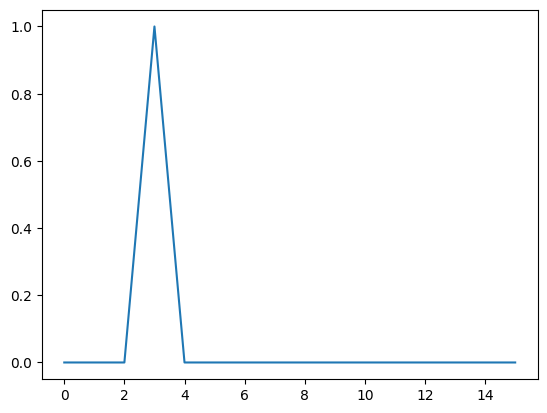

In [3]:
plt.plot(*generator.plot_rho(d=0, causal=True))
# plot_rho method returns an array for plot rho
# d specifies dimension of rho
# causal specifies whether the relation is causal or not. If it is causal then we plot rho(t-s) 

Exponential is a generate where $\rho(t,s) = (e^{-\lambda_0 (t-s)}, \dots,e^{-\lambda_d (t-s)} )$, we need to specify the $\lambda s$

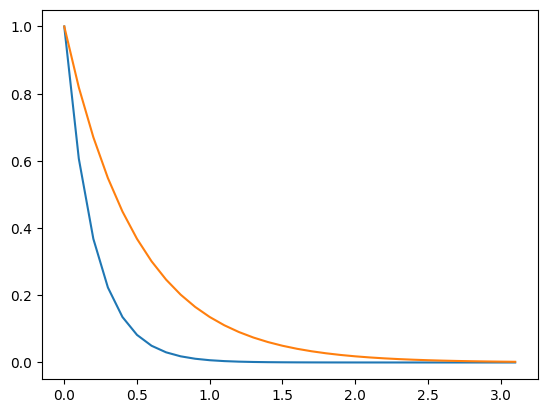

In [4]:
generator = Exponential({'input_dim':2, 'path_len':32, 'lambda':[0.5,0.2]})
plt.plot(*generator.plot_rho(d=0, causal=True))
plt.plot(*generator.plot_rho(d=1, causal=True))

TwoPart is defined by $\rho = e^{-\sigma*(t-s-c)^2}$

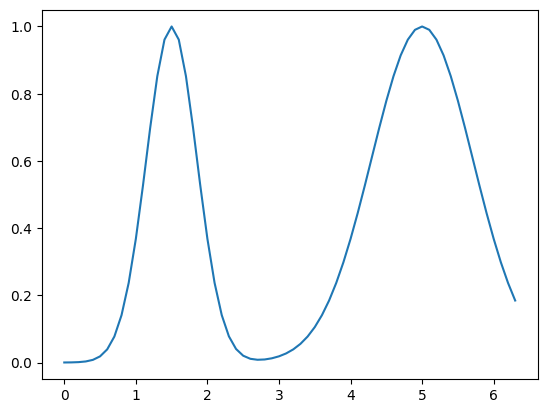

In [5]:
generator = TwoPart({'centers': [[1.5, 5]],'sigmas':[[4, 1]],'path_len':64})
plt.plot(*generator.plot_rho(d=0, causal=True))

ExpPeak is defined by $\rho = e^{-\lambda (t-s)} + e^{-\sigma*(t-s-c)^2}$, which is a exponential with a peak.

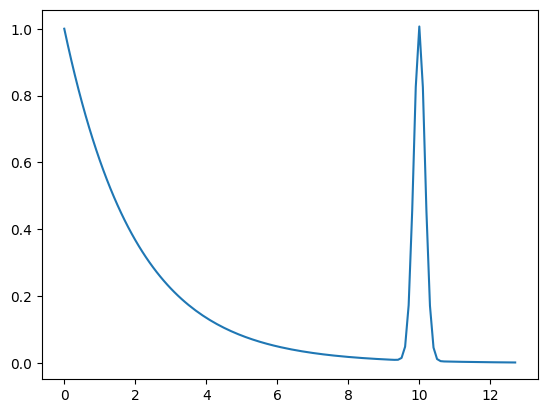

In [6]:
generator = ExpPeak({'lambda':[0.5], 'centers': [10],'sigmas':[20],'path_len':128})
plt.plot(*generator.plot_rho(d=0, causal=True))

The RNN we considers is 
$$\begin{align*}
h_{t+1} &= \sigma(Wh_{t} + Ux_{t} + b)\\
o_{t+1} &= c^\top h_{t+1}
\end{align*}$$ 
or a residual version writes as,
$$\begin{align*}
h_{t+1} &= h_t+ \sigma(Wh_{t} + Ux_{t} + b)\\
o_{t+1} &= c^\top h_{t+1}
\end{align*}$$ 

Next we look at an example.
Suppose we use a linear RNN with width 32 and we use the shift dataset. We run the same model on 10 dataset with different shifts, `[10,20,30,40,50,60,70,80,90,100]` and see how the error behaves. The codes for training the models are in `libs/train.py`, `shift_rnn()` method.

We plot the error against the shift distance which theoretically should be exponential increasing, but currently the result are not which we need to improve.


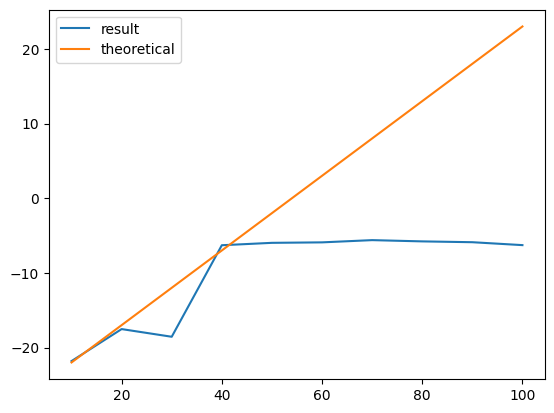

In [7]:
import pickle
import numpy as np
with open('runs/rnn_shift/res.pickle', 'rb') as handle:
    b = pickle.load(handle)
y = []
for l in b:
    y.append(np.log(l[0]['valid_loss']))
x = np.array([10,20,30,40,50,60,70,80,90,100])
plt.plot(x, y,label='result')
plt.plot(x,0.5*x-22-5, label='theoretical')
plt.legend()

We can look at the output of sequence `[1,0,0,0,0,...]` to see what kernel have the model learnt. (If want to run this code then needs to install the full requirements.)

In [1]:
from libs.seq2seq_model import LinearRNNModel
import torch
import matplotlib.pyplot as plt
import glob

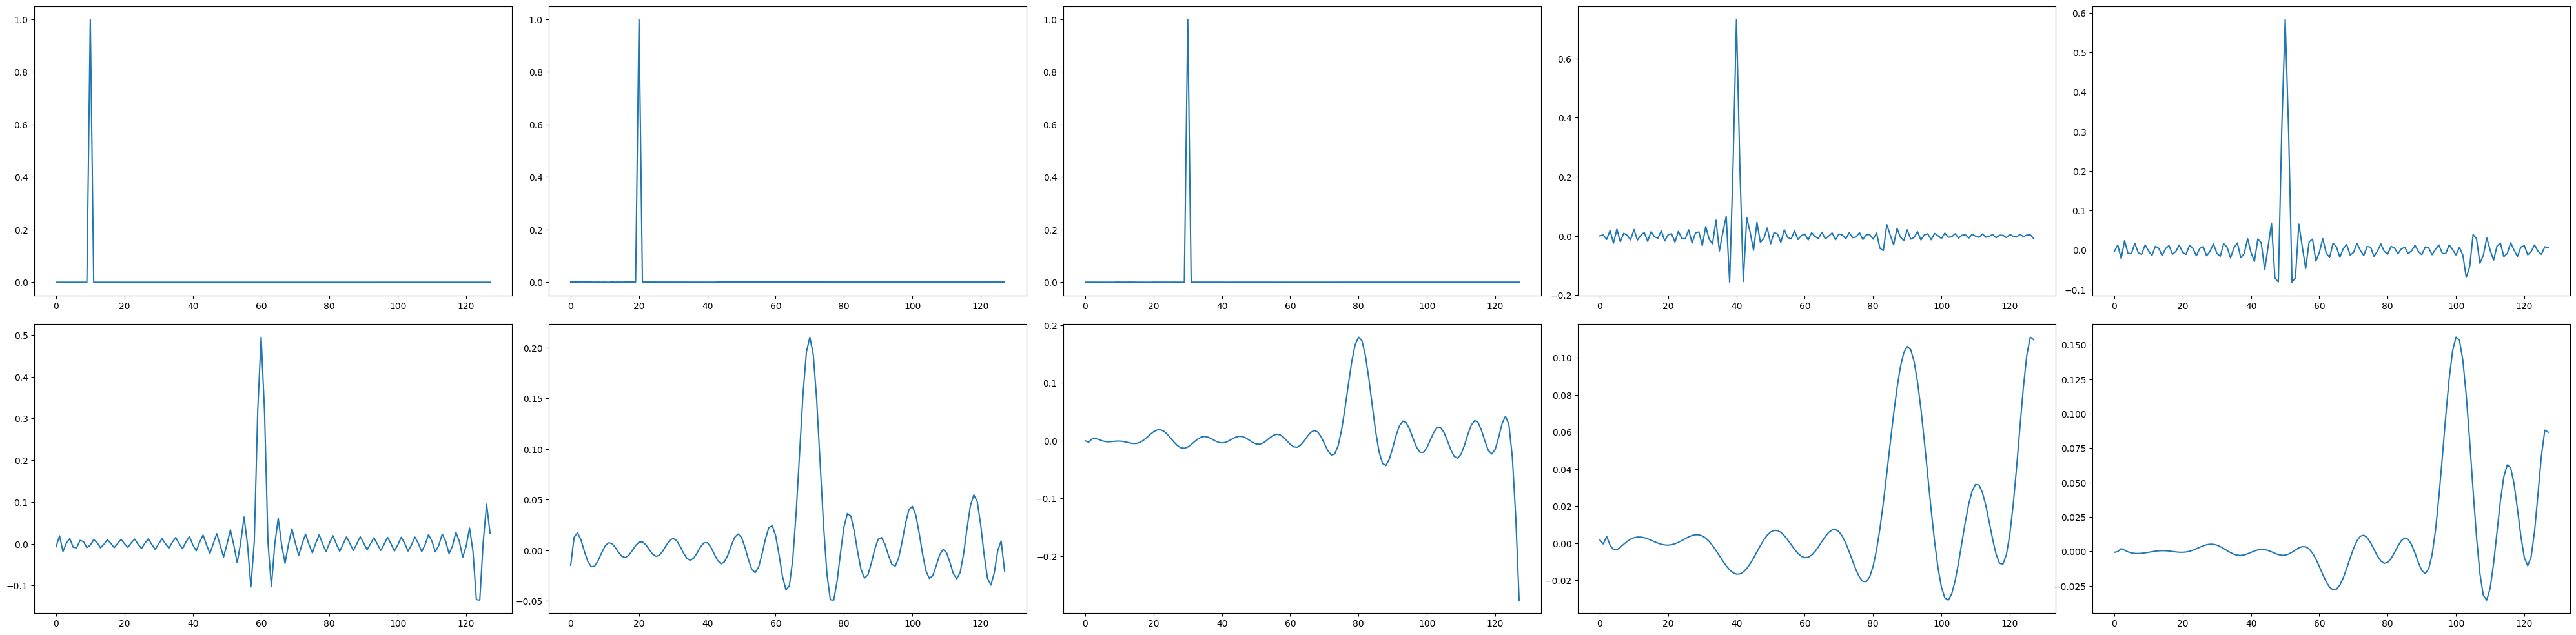

In [2]:
fig, ax = plt.subplots(2,5, figsize=(40,10))
plt.tight_layout()
for i in range(10):
    latest_file = max(glob.glob(f'runs/rnn_shift/version_{i}/checkpoints/*'), key=os.path.getctime)
    model = LinearRNNModel.load_from_checkpoint(latest_file)
    x = torch.zeros(1,128,1, dtype=torch.float)
    x[0,0,0]=1.0
    y = model(x).detach().numpy()
   
    ax.flat[i].plot(y[0])

We see that for shift distance less then 30 the model can learn the kernel quite well, but the larger then 40 the model behaves worse.